In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import requests

In [2]:
df = pd.read_excel("test.xlsx", sheet_name="Sheet3")
df.head()

,Month,Forecast
0,2026-01-01,6360
1,2026-02-01,17280
2,2026-03-01,17820
3,2026-04-01,24240
4,2026-05-01,33060


In [3]:
peak = df[df['Forecast']==df['Forecast'].max()]
peak

,Month,Forecast
34,2028-11-01,173460


In [4]:
net_sales = peak['Forecast'].values*(1+0.19)*0.5*0.4*20*(1-0.01)
net_sales

array([817412.904])

In [5]:
# request local host port 8000 for post simulation data with body

simulation_data = {
    "n_simulations": 10_000,
    "final_baseline_trend": 1_73_460,
    "event_params": [
        {"dist_type": "normal", "low": 0.04, "high": 0.15, "base": 0.10},
        {"dist_type": "uniform", "low": 0.06, "high": 0.10, "base": 0.08},
        {"dist_type": "uniform", "low": 0.01, "high": 0.01, "base": 0.01}
    ],
    "class_share_param": {"dist_type": "uniform", "low": 0.2, "high": 0.8, "base": 0.5},
    "product_share_param": {"dist_type": "uniform", "low": 0.4, "high": 0.5, "base": 0.4},
    "gross_price_param": {"dist_type": "uniform", "low": 20, "high": 20, "base": 20},
    "gtn_param": {"dist_type": "uniform", "low": 0.01, "high": 0.03, "base": 0.01}
}

response = requests.post("http://localhost:8000/simulate", json=simulation_data)
if response.status_code == 200:
    print("Simulation data posted successfully.")
else:
    print(f"Failed to post simulation data: {response.status_code} - {response.text}")



Simulation data posted successfully.


In [6]:
# convert the response to a DataFrame it has 2 dicts
simulation_response = response.json()
df_simulation = pd.DataFrame(simulation_response['all_results'])
summary = simulation_response['summary']
df_simulation.head()

,event_factors,class_share,product_share,brand_net_sales,sku_1_net_sales
0,0.143762,0.547552,0.459687,986517.27,986517.27
1,0.161451,0.476143,0.453538,844702.34,844702.34
2,0.192732,0.618098,0.464114,1156021.39,1156021.39
3,0.163897,0.234921,0.471992,438884.35,438884.35
4,0.122332,0.246488,0.499080,464877.36,464877.36


In [8]:
df_simulation.shape

(10000, 5)

## Approach 1

Approach 1: Scaling Factors
Scale each month's baseline net sales using percentile-based factor derived from peak month simulation.

- Calculate `base_net_sales` for the peak month using the same param structure.
- Get simulation percentiles: `p5, p10, ..., p95` for peak month net sales.
- Derive scaling factors = `pX / base_net_sales`
- Multiply every month's base forecast with each scaling factor to get:
`p5_range, p10_range, ..., p95_range`

In [9]:
base_peak = net_sales
base_forecast = df['Forecast'].values

In [10]:
base_peak, base_forecast

(array([817412.904]),
 array([  6360,  17280,  17820,  24240,  33060,  28680,  31980,  40500,
         34620,  37740,  48900,  40080,  43080,  60420,  51420,  56820,
         76320,  68820,  74220,  91440,  72900,  80880,  99840,  86280,
         88860, 126960,  98760, 100080, 125040, 109320, 117060, 155160,
        147600, 144900, 173460, 152580]))

In [11]:
range_forecasts = {}

for p in summary:
    scaling_factor = summary[p] / base_peak
    range_forecasts[p] = base_forecast * scaling_factor

In [12]:
range_forecasts_df = pd.DataFrame(range_forecasts)
range_forecasts_df.drop(columns=['mean', 'median', 'std', 'n_simulations'], inplace=True, errors='ignore')
range_forecasts_df.head()

,p5,p10,p25,p50,p75,p90,p95
0,3215.944466,3602.955327,4880.355867,7009.857218,9060.027496,10443.313051,11033.220737
1,8737.660435,9789.161643,13259.834808,19045.649799,24615.923763,28374.284515,29977.052569
2,9010.712324,10095.072944,13674.204646,19640.826355,25385.171381,29260.980906,30913.835462
3,12256.995888,13732.018416,18600.601605,26716.814301,34530.670835,39802.815777,42051.143187
4,16716.843402,18728.569671,25368.642289,36438.031385,47095.048589,54285.523498,57351.930435


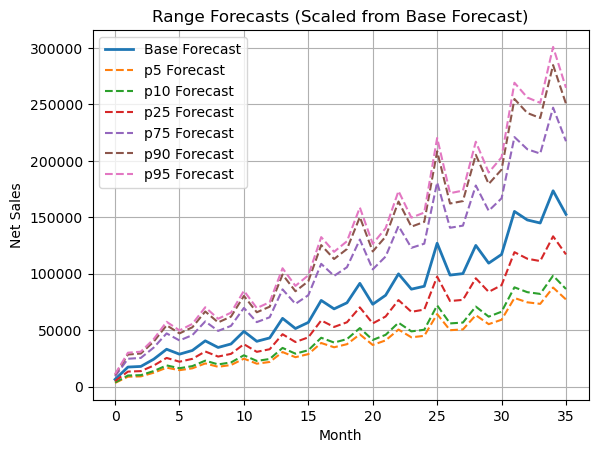

In [13]:
# Step 3: Plot
plt.plot(base_forecast, label='Base Forecast', linewidth=2)

for p in ['p5', 'p10', 'p25', 'p75', 'p90', 'p95']:
    plt.plot(range_forecasts[p], label=f'{p} Forecast', linestyle='--')

plt.title('Range Forecasts (Scaled from Base Forecast)')
plt.xlabel('Month')
plt.ylabel('Net Sales')
plt.legend()
plt.grid(True)
plt.show()


## Approach 2
Approach 2: Uptake Profile
Assume `peak month = 100%` and scale other months down based on relative uptake curve.

Choose an uptake curve `(e.g., [40, 60, 75, 90, 100, 95, 80, 60, 40] around peak month)`.
- For each simulation percentile `(p5 to p95)`:
- Treat that percentile value as the peak `(100%)`
- Scale all other months by the `uptake % × that percentile value`

In [14]:
forecast_trend = df['Forecast'].values
uptake = forecast_trend / net_sales

uptake_df = pd.DataFrame({
    'Month': np.arange(1, len(forecast_trend) + 1),
    'Forecast': forecast_trend,
    'Uptake': np.round(uptake, 3)
})

In [15]:
uptake_df.head()

,Month,Forecast,Uptake
0,1,6360,0.008
1,2,17280,0.021
2,3,17820,0.022
3,4,24240,0.030
4,5,33060,0.040


In [16]:
summary = pd.DataFrame([summary])
summary.drop(columns=['mean', 'median', 'std', 'n_simulations'], inplace=True, errors='ignore')
summary.head()

,p5,p10,p25,p50,p75,p90,p95
0,413326.18,463066.38,627243.06,900935.18,1164431.35,1342216.8,1418034.12


In [17]:
for p in ['p5', 'p10', 'p25', 'p75', 'p90', 'p95']:
    uptake_df[p] = uptake_df['Uptake'] * summary[p].values
uptake_df.head()

,Month,Forecast,Uptake,p5,p10,p25,p75,p90,p95
0,1,6360,0.008,3306.60944,3704.53104,5017.94448,9315.45080,10737.7344,11344.27296
1,2,17280,0.021,8679.84978,9724.39398,13172.10426,24453.05835,28186.5528,29778.71652
2,3,17820,0.022,9093.17596,10187.46036,13799.34732,25617.48970,29528.7696,31196.75064
3,4,24240,0.030,12399.78540,13891.99140,18817.29180,34932.94050,40266.5040,42541.02360
4,5,33060,0.040,16533.04720,18522.65520,25089.72240,46577.25400,53688.6720,56721.36480


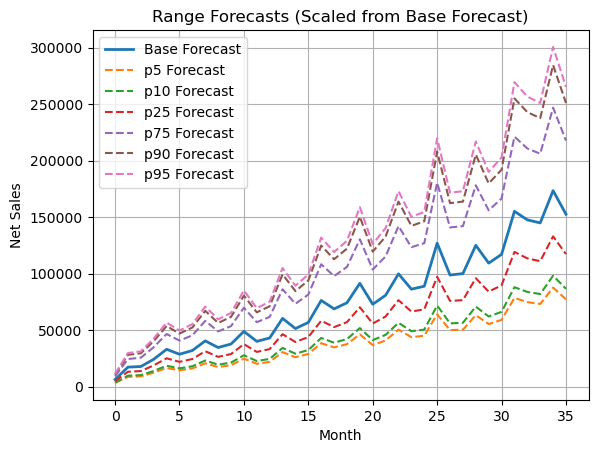

In [18]:
# Step 3: Plot
plt.plot(uptake_df['Forecast'], label='Base Forecast', linewidth=2)

for p in ['p5', 'p10', 'p25', 'p75', 'p90', 'p95']:
    plt.plot(uptake_df[p], label=f'{p} Forecast', linestyle='--')

plt.title('Range Forecasts (Scaled from Base Forecast)')
plt.xlabel('Month')
plt.ylabel('Net Sales')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# export summary and df_simulation and approach 1 and 2 results to excel file
with pd.ExcelWriter("simulation_results.xlsx") as writer:
    df_simulation.to_excel(writer, sheet_name='Simulation Results', index=False)
    summary.to_excel(writer, sheet_name='Summary', index=False)
    uptake_df.to_excel(writer, sheet_name='Uptake Forecast', index=False)
    range_forecasts_df.to_excel(writer, sheet_name='Range Forecasts', index=False)
